Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [1]:
# !pip install wandb -qU

In [2]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: yanzhang7271 (-yanzhang). Use `wandb login --relogin` to force relogin


True

In [3]:
# wandb: Currently logged in as: yanzhang7271 (-yanzhang). Use `wandb login --relogin` to force relogin
# pip install wandb

In [4]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


import matplotlib.pyplot as plt

np.random.seed(0)

In [5]:
import wandb

In [6]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
JPEGIMAGES_FOLDER_PATH = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/JPEGImages/"
path_project = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/"

In [7]:
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)
print(labels_dirs)
len(labels_dirs) # 50 labels / subdirectories

['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


50

In [8]:
def get_num_label(label):
    return labels_dirs.index(labels_dirs)

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [9]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()

In [10]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH) : 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """

    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Deleted existent annotations.csv file.
 ---------------------------
Sucessfully created annotations.csv file.


In [11]:
class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
dataset = AWA2Dataset()

## TODO : Change transforms. Currently this is not useful.
dataset.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    transforms.CenterCrop((224,224)),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the reaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

# Testing. All good
random_index = np.random.randint(0, len(dataset))
image, label = dataset[random_index]

In [13]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=16, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 


###   AlexNet  ###

In [14]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

#Model description
AlexNet_model.eval()

Using cache found in C:\Users\1/.cache\torch\hub\pytorch_vision_v0.6.0
D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### CUDA ###

In [15]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [16]:
torch.cuda.is_available()

True

### Question: nombre de noeud ###

In [17]:
nb_noeud = 4096

In [18]:
AlexNet_model.classifier[4] = torch.nn.Linear(4096,nb_noeud)
AlexNet_model.classifier[6] = torch.nn.Linear(nb_noeud,50)

In [19]:
import sys
print(sys.version)

3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]


In [20]:
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Question: check dimension de dataloader   ###

###  Split training data and test data ###

In [21]:
batch_size = 128

In [22]:
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

In [23]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])

In [24]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

###   transfomer labels  ###

In [25]:
path_class = path_project +"classes.txt"
class_animal = pd.read_table(path_class,header= None)

In [26]:
animals = class_animal[1]

In [27]:
dict_label_animal = {}

In [28]:
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1

In [29]:
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels)   

###   Loss function  ###

In [30]:
lr = 0.0001

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(AlexNet_model.parameters(), lr= lr)

In [32]:
torch.cuda.empty_cache()

###  Training  ###

In [33]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AlexNet",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "AlexNet",
    "dataset": "AWA2",
    "epochs": 50,
    }
)

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()


        # log metrics to wandb
        wandb.log({"loss": running_loss, "acc": (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)})
        
        running_loss = 0.0
    print("epoch: "+str(epoch))    

print('Finished Training of AlexNet')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
Finished Training of AlexNet


### Test ###

In [34]:
correct = 0
total = 0
wrong_pred =[]
right_label = []
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        

        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 36 %


###   Analyse  ###

In [35]:
nb_label_wrongpred = []
for i in range(0,50):
    nb_label_wrongpred.append(right_label.count(i))

In [36]:
list_animal = list(dict_label_animal.keys())

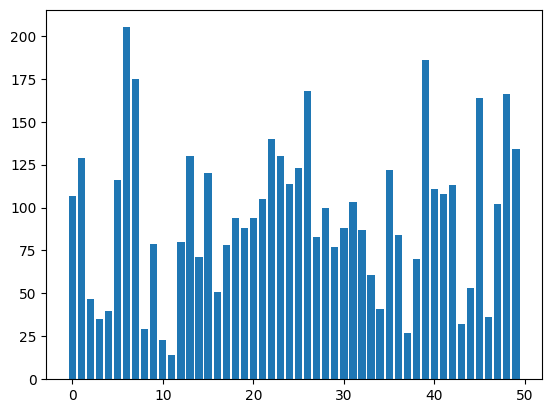

In [37]:
plt.bar(range(50),nb_label_wrongpred)
plt.show()

In [38]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_label_wrongpred[i]<=5:
        good_classification.append(i)
    if    nb_label_wrongpred[i]>=60:
        bad_classification.append(i)

In [39]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(right_label) if x == m]:
        wrong_pred_m.append(wrong_pred[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [40]:
for i in good_classification :
    print('Alexnet a bien classifie '+animals[i])

In [41]:
for i in bad_classification:
    print('Alexnet a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

Alexnet a mal classifie antelope , melange souvent avec deer
Alexnet a mal classifie grizzly+bear , melange souvent avec gorilla
Alexnet a mal classifie persian+cat , melange souvent avec chihuahua
Alexnet a mal classifie horse , melange souvent avec cow
Alexnet a mal classifie german+shepherd , melange souvent avec chihuahua
Alexnet a mal classifie siamese+cat , melange souvent avec chihuahua
Alexnet a mal classifie tiger , melange souvent avec giraffe
Alexnet a mal classifie hippopotamus , melange souvent avec rhinoceros
Alexnet a mal classifie leopard , melange souvent avec giraffe
Alexnet a mal classifie moose , melange souvent avec ox
Alexnet a mal classifie humpback+whale , melange souvent avec blue+whale
Alexnet a mal classifie elephant , melange souvent avec ox
Alexnet a mal classifie gorilla , melange souvent avec chimpanzee
Alexnet a mal classifie ox , melange souvent avec cow
Alexnet a mal classifie fox , melange souvent avec squirrel
Alexnet a mal classifie sheep , melange 

In [42]:
anno = pd.read_csv("annotations.csv",header=None)[1]

In [43]:
anno_list =list(anno)

In [44]:
for animal in animals:
    print("Il y a " + str(anno_list.count(animal)) +" "+ animal  )

Il y a 1046 antelope
Il y a 852 grizzly+bear
Il y a 291 killer+whale
Il y a 193 beaver
Il y a 549 dalmatian
Il y a 747 persian+cat
Il y a 1645 horse
Il y a 1033 german+shepherd
Il y a 174 blue+whale
Il y a 500 siamese+cat
Il y a 188 skunk
Il y a 100 mole
Il y a 877 tiger
Il y a 684 hippopotamus
Il y a 720 leopard
Il y a 704 moose
Il y a 291 spider+monkey
Il y a 709 humpback+whale
Il y a 1038 elephant
Il y a 872 gorilla
Il y a 728 ox
Il y a 664 fox
Il y a 1420 sheep
Il y a 988 seal
Il y a 728 chimpanzee
Il y a 779 hamster
Il y a 1200 squirrel
Il y a 696 rhinoceros
Il y a 1088 rabbit
Il y a 383 bat
Il y a 1202 giraffe
Il y a 589 wolf
Il y a 567 chihuahua
Il y a 310 rat
Il y a 272 weasel
Il y a 758 otter
Il y a 895 buffalo
Il y a 1170 zebra
Il y a 874 giant+panda
Il y a 1344 deer
Il y a 630 bobcat
Il y a 713 pig
Il y a 1019 lion
Il y a 185 mouse
Il y a 868 polar+bear
Il y a 1028 collie
Il y a 215 walrus
Il y a 512 raccoon
Il y a 1338 cow
Il y a 946 dolphin


### Conclusion ###

Alexnet a une très bien performance en classification des animaux. Mais il a même la difficulté à classifer deux animaux similaires.
À faire:
1.Étudier si VIT a une meilleure performance à classifer deux animaux similaire.
2.Essayer de comprendre la logique de la construction de AlexNet